In [47]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import random,os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict


from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
overall=dict()

# Load the stock price or the blockchain or the json, (good to have api call for and load the json) let's choose ETH--Aider
# Import Drive API and authenticate.
# from google.colab import drive
# # Mount your Drive to the Colab VM.
# drive.mount('/content/gdrive')

def build_df(path_to_parquet_file, array_with_our_choices):

  # reading the big df with all assets
  all_assets = pd.DataFrame()
  all_assets = pd.read_parquet(path_to_parquet_file)

  # resetting index and cleaning column names from bull shit
  all_assets.reset_index(inplace=True)
  all_assets.columns = [c.split('.')[-1].replace('_','') for c in all_assets.columns]

  # array with all unqiue symbols from MAIN FILE
  all_symbols = all_assets["symbol"].unique()

  # list to store our small dataframes with our chosen assets
  list_of_df = list()

# just in case, this is very important --> below is for loop haha

  for symbol in array_with_our_choices:

    # temp df for slicing main big df
    temp_df = pd.DataFrame()
    temp_df = all_assets.loc[all_assets['symbol'] == symbol]

    # small df for processing stuff and storing in our list_of_df
    small_df = pd.DataFrame()
    small_df = temp_df[['timeclose', 'close', 'marketcap', 'volume']]
    small_df['timeclose'] = pd.to_datetime(small_df['timeclose'])

    small_df = small_df.set_index(['timeclose'])

    # inserting column for "returns"
    small_df.insert(1, 'returns', small_df['close'].pct_change())
    small_df = small_df.rename(columns={'close' : 'price'})

    # renaming columns based on the symbol that we are looping at
    small_df.columns = [c.replace(c, symbol+'_'+c) for c in small_df.columns]

    # pasting to our list
    list_of_df.append(small_df)

  # final dataframe with beatufilly structured chosen assets
  final_df = pd.DataFrame()

  # looping thru our chosen assets in our list
  for df in list_of_df:
    final_df = final_df.join(df, how='outer')


  return final_df


In [48]:
path_to_file = 'hourly.parquet.gzip'

# LIST HERE WHAT ASSETS WE WANT TO WORK WITH. HERE IS JUST AN EXAMPLE OF 3 ASSETS TO TEST FUNCTION
our_choices = ['ETH']

# new final df
df = build_df(path_to_file, our_choices)
df.head()
# printing our FINAL TEST_DF
# look how beatiful it is, and I hope this function will be a bit useful for our work



/var/folders/qf/p1jx3hqj5vv1t6n49gjv_wjw0000gn/T/ipykernel_72276/439658689.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['timeclose'] = pd.to_datetime(small_df['timeclose'])


,ETH_price,ETH_returns,ETH_marketcap,ETH_volume
timeclose,,,,
2019-01-01 20:59:59.999000+00:00,140.346549,NaN,1.461575e+10,NaN
2019-01-01 21:59:59.999000+00:00,139.695956,-0.004636,1.454810e+10,NaN
2019-01-01 22:59:59.999000+00:00,139.968871,0.001954,1.457664e+10,NaN
2019-01-01 23:59:59.999000+00:00,140.819413,0.006077,1.466532e+10,NaN
2019-01-02 00:59:59.999000+00:00,141.995471,0.008352,1.478792e+10,NaN


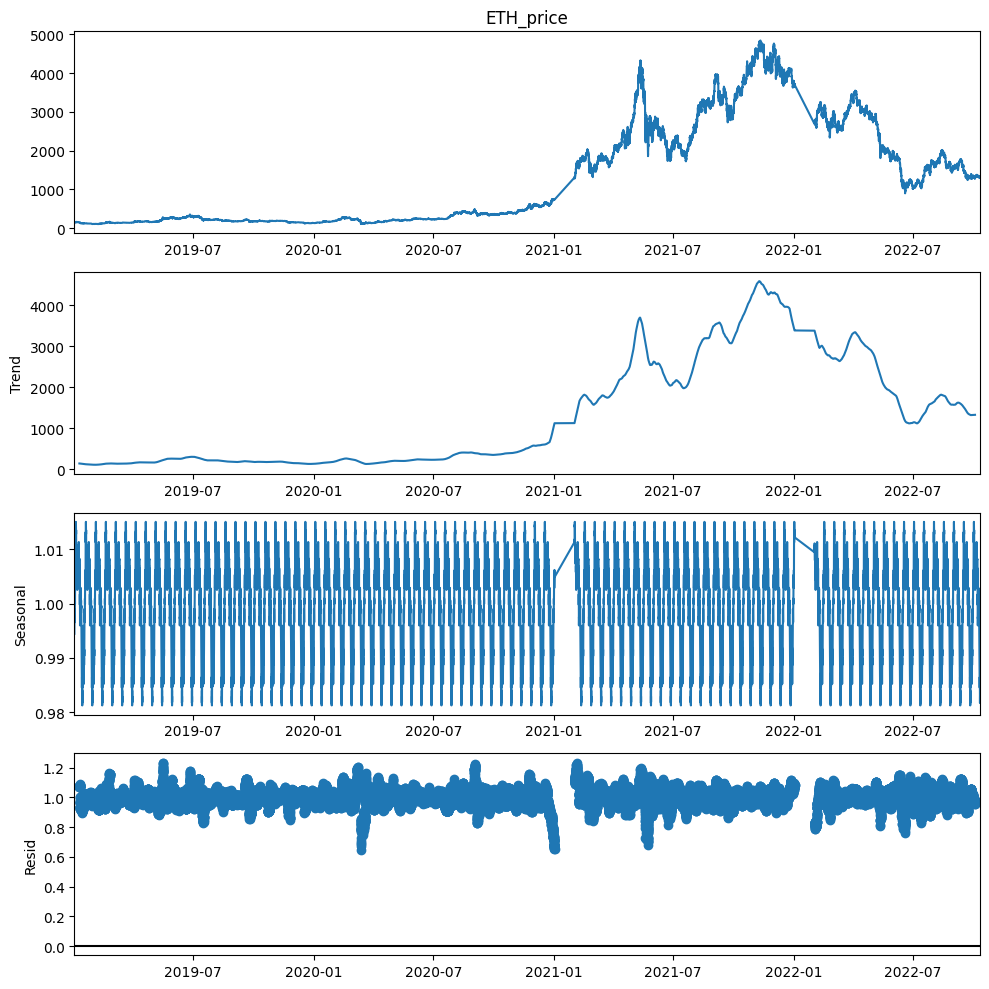

In [49]:
#EDA plot the graph and transfer the data in the certain format . date(index)...price... seperate the dataset to training set and test set(might need the cross-validation)--Adri--
# fig, ax = plt.subplots()
# prices = df['ETH_price'].values.reshape(-1, 1)
#
# ax.plot(df.index, prices)
# ax.set(title=f"{our_choices[0]}'s price",
#        xlabel='Time',
#        ylabel='Price ($)');
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['ETH_price'], model = 'multiplicative',period=365)
plt.rcParams['figure.figsize'] = [10,10]
decomposition.plot()
plt.show()

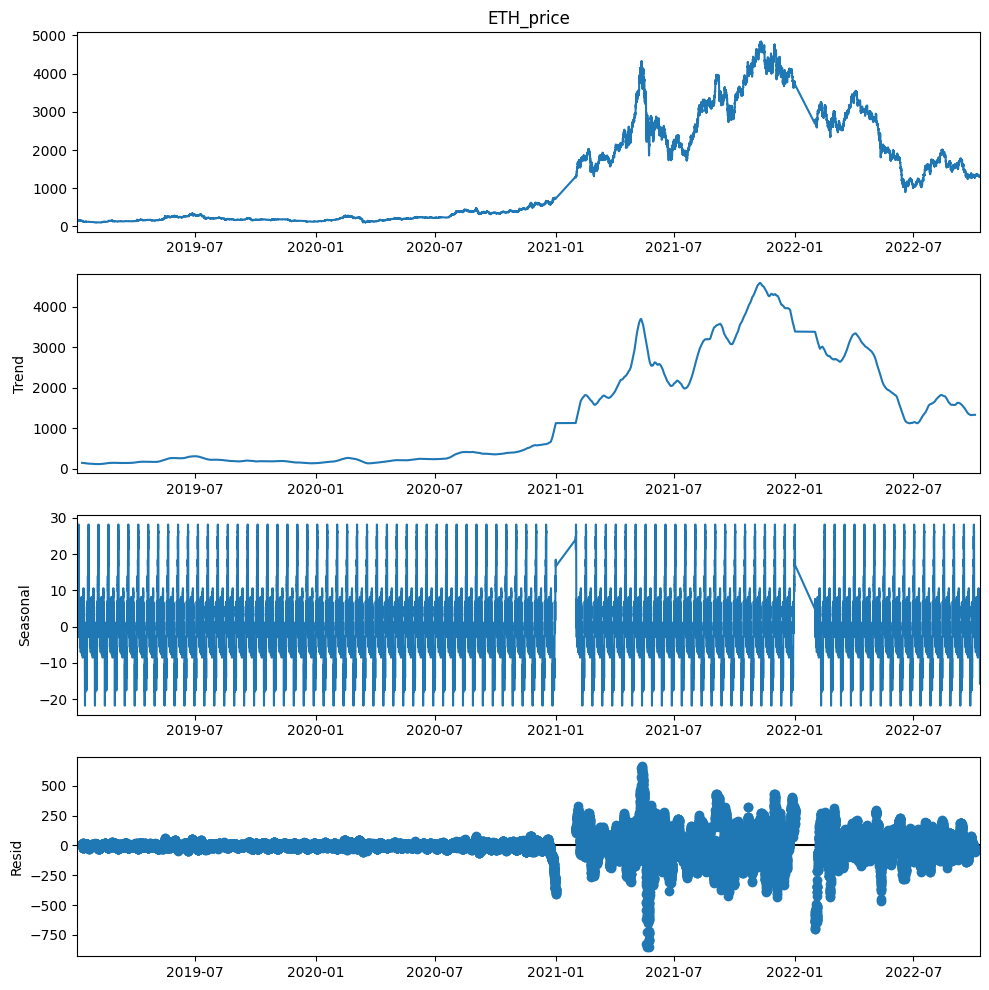

In [50]:
decomposition = sm.tsa.seasonal_decompose(df['ETH_price'], model = 'additive',period=365)
plt.rcParams['figure.figsize'] = [10,10]
decomposition.plot()
plt.show()

In [51]:

def splitData(df,train_percent):
  min_date = df.index.min()
  max_date = df.index.max()
  time_between = max_date - min_date
  train_cutoff = min_date + train_percent*time_between
  train_cutoff
  train_df = df[df.index <= train_cutoff]
  test_df = df[df.index > train_cutoff]
  return train_df,test_df



In [52]:
df['ds'] = df.index.tz_convert(None)
df['y'] = df['ETH_price']
df['add1'] = df['ETH_marketcap'].shift(1)
df.dropna(subset=['add1'],inplace=True)
train_df,test_df=splitData(df,0.9)
display(df.head())
print("Train:", train_df.index.min(), train_df.index.max())
print("Test:", test_df.index.min(), test_df.index.max())

,ETH_price,ETH_returns,ETH_marketcap,ETH_volume,ds,y,add1
timeclose,,,,,,,
2019-01-01 21:59:59.999000+00:00,139.695956,-0.004636,1.454810e+10,NaN,2019-01-01 21:59:59.999,139.695956,1.461575e+10
2019-01-01 22:59:59.999000+00:00,139.968871,0.001954,1.457664e+10,NaN,2019-01-01 22:59:59.999,139.968871,1.454810e+10
2019-01-01 23:59:59.999000+00:00,140.819413,0.006077,1.466532e+10,NaN,2019-01-01 23:59:59.999,140.819413,1.457664e+10
2019-01-02 00:59:59.999000+00:00,141.995471,0.008352,1.478792e+10,NaN,2019-01-02 00:59:59.999,141.995471,1.466532e+10
2019-01-02 01:59:59.999000+00:00,141.125948,-0.006124,1.469747e+10,NaN,2019-01-02 01:59:59.999,141.125948,1.478792e+10


Train: 2019-01-01 21:59:59.999000+00:00 2022-05-26 00:59:59.999000+00:00
Test: 2022-05-26 01:59:59.999000+00:00 2022-10-10 19:59:59.999000+00:00


In [53]:
from sklearn.linear_model import LinearRegression


#Regression model there are two way to do it. ( shift the datetime )--sinuo
def autocorr_model(eth_df, days_lag):

    ### BEGIN SOLUTION ###

    # Add column containing the value at t-1
    eth_df['PreETH_price'] = eth_df['ETH_price'].shift() #Add new column containing count at days_lag
    eth_df = eth_df.iloc[days_lag:]

    # Create a single-variable linear regression
    model = LinearRegression()
    model.fit(X=eth_df['PreETH_price'].values.reshape(-1, 1), y=eth_df['ETH_price'])

    # Get in-sample predictions for the days in the month
    preds = model.predict(eth_df['PreETH_price'].values.reshape(-1, 1))
    resids = eth_df['ETH_price'] - preds

    return model, preds, resids


The training model is: y = 1.000x + 0.193
The simple linear model has R^2=1.000 and MAE=8.01


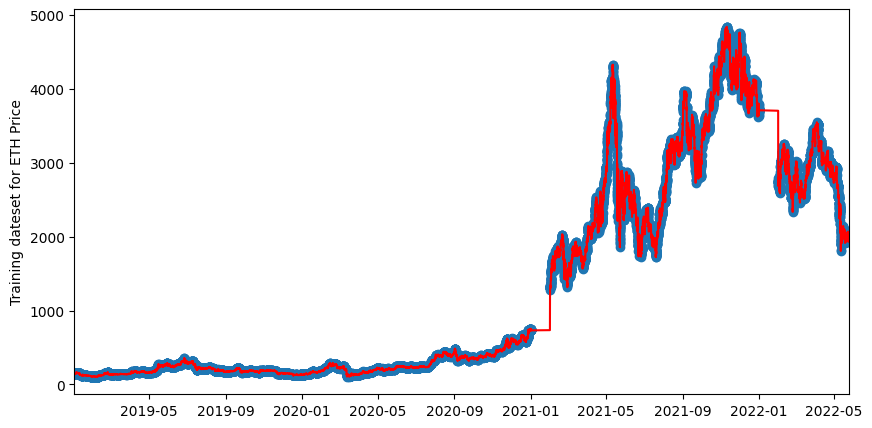

In [54]:
regressionData = train_df.copy()

days_lag = 1
model, preds, resids = autocorr_model(regressionData,days_lag)

# Display the model
print('The training model is: y = {:.3f}x + {:.3f}'.format(model.coef_[0], model.intercept_))
mse = np.sum(abs(resids),axis=0)/len(resids)
r2 = 1 - mse/np.var(regressionData['ETH_price'][days_lag:])
# Calculate and display the model performance statistics

overall['linear_regression_autocorr']={'train': {'mae':mse,"r2":r2}}
print('The simple linear model has R^2={:.3f} and MAE={:.2f}'.format(r2,mse))
# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'])
plt.plot(regressionData.index[days_lag:], preds,color='red')
plt.xlim((regressionData.index[days_lag:].min(),regressionData.index[days_lag:].max()))
plt.ylabel('Training dateset for ETH Price')
plt.show()

The simple linear model has R^2=0.997,MAE=8.92


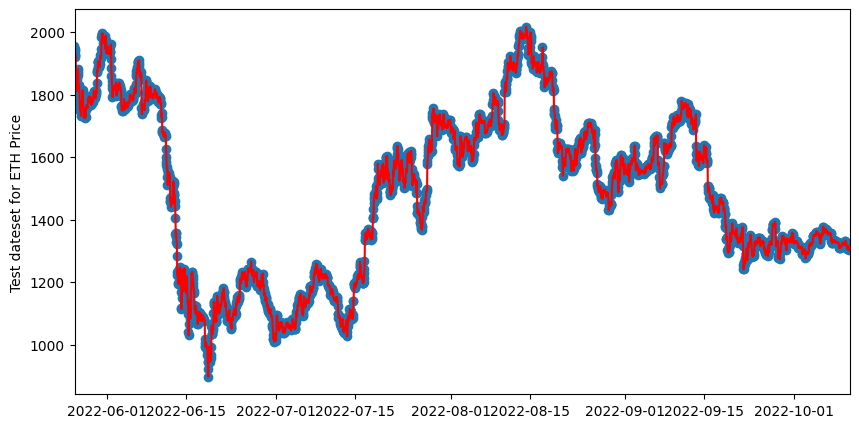

In [55]:
from sklearn.metrics import r2_score,mean_absolute_error
regressionData = test_df.copy()
regressionData['PreETH_price'] = regressionData['ETH_price'].shift()
regressionData = regressionData.iloc[1:]
preds = model.predict(regressionData['PreETH_price'].values.reshape(-1, 1))

r2_auto = r2_score(regressionData['ETH_price'], preds)
mae_auto = mean_absolute_error(regressionData['ETH_price'], preds)
print('The simple linear model has R^2={:.3f},MAE={:.2f}'.format(r2_auto, mae_auto))

overall['linear_regression_autocorr']['test']={'mae':mae_auto,"r2":r2_auto}

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'])
plt.plot(regressionData.index, preds,color='red')
plt.xlim((regressionData.index[days_lag:].min(),regressionData.index[days_lag:].max()))
plt.ylabel('Test dateset for ETH Price')
plt.show()


In [56]:
#Regression model there are two way to do it. (1. deal with the dummy datetime date )
def model_trend_seasonality(df_trending):
    '''
    Performs linear regression incorporating both trend (using days passed as a feature) and weekly seasonality (using day of week)

    Inputs:
        flights_per_day(pd.Series): series containing the count of flights per day, with date as the index

    Returns:
        model(sklearn.linear_model.LinearRegression()): trained linear regression model
        preds(np.ndarray): array containing the in-sample predictions
        resids(np.ndarray): array containing the errors of the in-sample predictions
    '''

    ### BEGIN SOLUTION ###

    df_trending['Day_of_hour'] = df_trending.index.hour

    fullmodel_encoded = pd.get_dummies(data = df_trending, columns=['Day_of_hour'])
    fullmodel_encoded['Days'] = (fullmodel_encoded.index-fullmodel_encoded.index.min()).days
    fullmodel_encoded['ETH_marketcap'] = fullmodel_encoded['ETH_marketcap'].shift()

    # Create a linear regression and fit it to the data
    model = LinearRegression()
    X = fullmodel_encoded.drop(['ETH_price', 'ETH_volume','ds','y','add1','ETH_returns'],axis=1).iloc[1:]
    display(X.head())

    y = fullmodel_encoded['ETH_price'].iloc[1:]
    model.fit(X, y)

    # Get in-sample predictions (on the training set)
    preds = model.predict(X)
    fullmodel_encoded=fullmodel_encoded.iloc[1:]
    # Add predictions and residuals to the dataframe
    fullmodel_encoded['Preds'] = preds
    fullmodel_encoded['resids']=fullmodel_encoded['ETH_price']-fullmodel_encoded['Preds']
    resids = fullmodel_encoded['ETH_price']-fullmodel_encoded['Preds']

    return model, preds, resids,fullmodel_encoded,X


,ETH_marketcap,Day_of_hour_0,Day_of_hour_1,Day_of_hour_2,Day_of_hour_3,Day_of_hour_4,Day_of_hour_5,Day_of_hour_6,Day_of_hour_7,Day_of_hour_8,...,Day_of_hour_15,Day_of_hour_16,Day_of_hour_17,Day_of_hour_18,Day_of_hour_19,Day_of_hour_20,Day_of_hour_21,Day_of_hour_22,Day_of_hour_23,Days
timeclose,,,,,,,,,,,,,,,,,,,,,
2019-01-01 22:59:59.999000+00:00,1.454810e+10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2019-01-01 23:59:59.999000+00:00,1.457664e+10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-02 00:59:59.999000+00:00,1.466532e+10,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-02 01:59:59.999000+00:00,1.478792e+10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-02 02:59:59.999000+00:00,1.469747e+10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The fitted model is:
y = 30.53 + 0.00*ETH_marketcap + -0.73*Day_of_hour_0 + 0.40*Day_of_hour_1 + -1.16*Day_of_hour_2 + -0.76*Day_of_hour_3 + 0.17*Day_of_hour_4 + 0.60*Day_of_hour_5 + 0.15*Day_of_hour_6 + 0.33*Day_of_hour_7 + -0.13*Day_of_hour_8 + -0.51*Day_of_hour_9 + 0.15*Day_of_hour_10 + -0.19*Day_of_hour_11 + 0.04*Day_of_hour_12 + 1.23*Day_of_hour_13 + -1.22*Day_of_hour_14 + 0.06*Day_of_hour_15 + 0.37*Day_of_hour_16 + -0.54*Day_of_hour_17 + 0.13*Day_of_hour_18 + 0.36*Day_of_hour_19 + -0.26*Day_of_hour_20 + 1.38*Day_of_hour_21 + 0.11*Day_of_hour_22 + 0.04*Day_of_hour_23 + -0.03*Days
The simple linear model has R^2=1.000,MAE=18.79


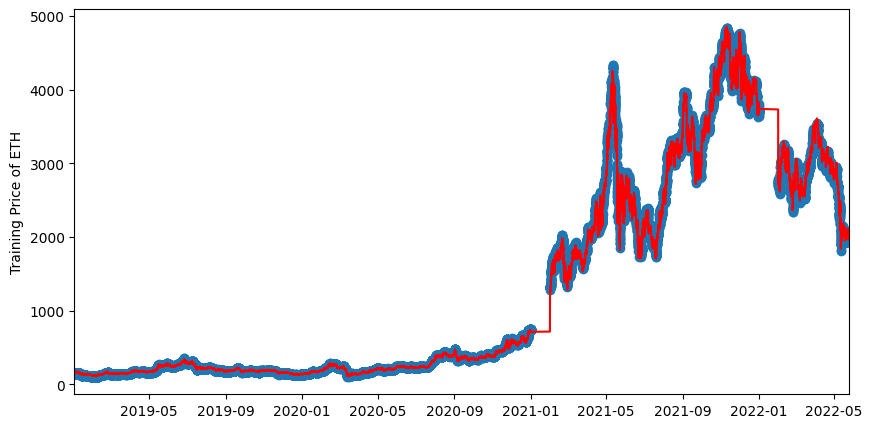

In [57]:
full_model, preds, resids,real,X = model_trend_seasonality(train_df.copy())

# Calculate the model performance statistics
# mse = np.sum(resids**2,axis=0)/flights_per_day.shape[0]
# r2 = 1 - np.sum((resids)**2)/np.sum((flights_per_day-np.mean(flights_per_day))**2)

# Display the model and performance metrics
print('The fitted model is:')
# Get the equation for the model
coef = full_model.coef_
intercept = full_model.intercept_

# Print out the equation
equation = 'y = {:.2f} + '.format(intercept) + ' + '.join(['{:.2f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print(equation)

r2_autocorr = r2_score(real['ETH_price'], preds)
mae_autocorr = mean_absolute_error(real['ETH_price'], preds)
print('The simple linear model has R^2={:.3f},MAE={:.2f}'.format(r2_autocorr, mae_autocorr))

overall['linear_regression_seasonality']={'train': {'mae':mae_autocorr,"r2":r2_autocorr}}

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=real.index, y=real['ETH_price'])
plt.plot(real.index, preds,color='red')
plt.xlim((real.index.min(),real.index.max()))
plt.ylabel('Training Price of ETH')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


The simple linear model has R^2=0.976,MAE=33.44


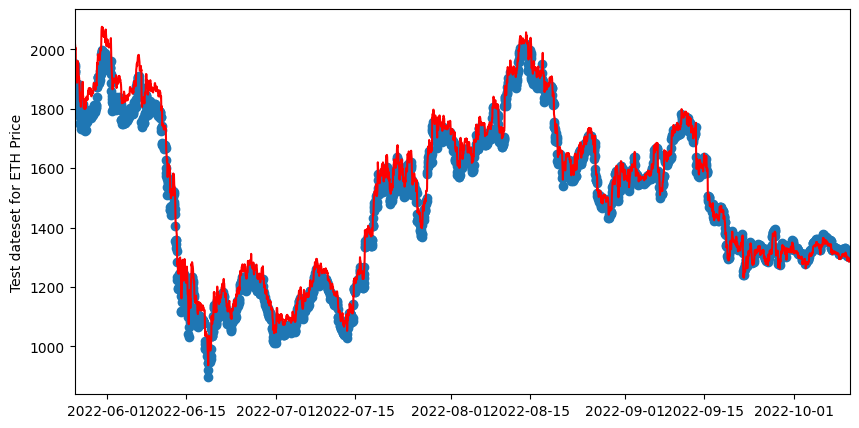

In [58]:
from sklearn.metrics import r2_score,mean_absolute_error
regressionData = test_df.copy()
regressionData['Days'] = (regressionData.index-regressionData.index.min()).days
regressionData['Day_of_hour'] = regressionData.index.hour
regressionData = pd.get_dummies(data = regressionData, columns=['Day_of_hour'])
regressionData['ETH_marketcap'] = regressionData['ETH_marketcap'].shift()
regressionData = regressionData.iloc[1:]
X = regressionData.drop(['ETH_price', 'ETH_volume','ds','y','add1','ETH_returns'],axis=1)
preds = full_model.predict(X)
r2_test_season = r2_score(regressionData['ETH_price'], preds)
mae_test_season = mean_absolute_error(regressionData['ETH_price'], preds)
print('The simple linear model has R^2={:.3f},MAE={:.2f}'.format(r2_test_season, mae_test_season))
overall['linear_regression_seasonality']['test']={'mae':mae_test_season,"r2":r2_test_season}

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'])
plt.plot(regressionData.index, preds,color='red')
plt.xlim((regressionData.index[days_lag:].min(),regressionData.index[days_lag:].max()))
plt.ylabel('Test dateset for ETH Price')
plt.show()


In [59]:
#LSTM model

BATCH_SIZE=60
N_EPOCHS = 60

def create_input_data(series, n_lags=1, n_leads=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.

    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features
    n_leads : int
        The number of future periods we want to forecast for

    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X = []
    y = []
    for step in range(len(series) - n_lags - n_leads + 1):
        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end][0][0])
    return np.array(X), np.array(y)

# custom function for reproducibility


def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
prices = df[['ETH_price','ETH_marketcap']].values


In [60]:

valid_size = test_df.shape[0]
valid_ind = len(prices) - valid_size


minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

# prices_scaled = np.concatenate((prices_train,
#                                 prices_valid)).flatten()
prices_scaled = np.concatenate((prices_train,
                                prices_valid))

prices_scaled.shape

(31675, 2)

In [61]:
X, y = create_input_data(prices_scaled, 12)
y=y.reshape(-1,1)

print(X.shape,y.shape)



(31663, 12, 2) (31663, 1)


In [62]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size
print(X.shape[0],X.shape[1],1)
# X_tensor = torch.from_numpy(X).float().reshape(X.shape[0],
#                                                X.shape[1],
#                                                2)
X_tensor = torch.from_numpy(X).float().reshape(X.shape[0],
                                               X.shape[1],
                                               2)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE)

31663 12 1


In [63]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size,
                          n_layers, batch_first=True,
                          nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:,-1,:])
        return output


In [64]:
model = RNN(input_size=2, hidden_size=6,
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), 'eth_rnn_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 0.0872 	 Valid. loss: 0.0047
<10> - Train. loss: 0.0050 	 Valid. loss: 0.0041
<20> - Train. loss: 0.0045 	 Valid. loss: 0.0058
<30> - Train. loss: 0.0041 	 Valid. loss: 0.0036
<40> - Train. loss: 0.0040 	 Valid. loss: 0.0028
<50> - Train. loss: 0.0039 	 Valid. loss: 0.0034
Lowest loss recorded in epoch: 58


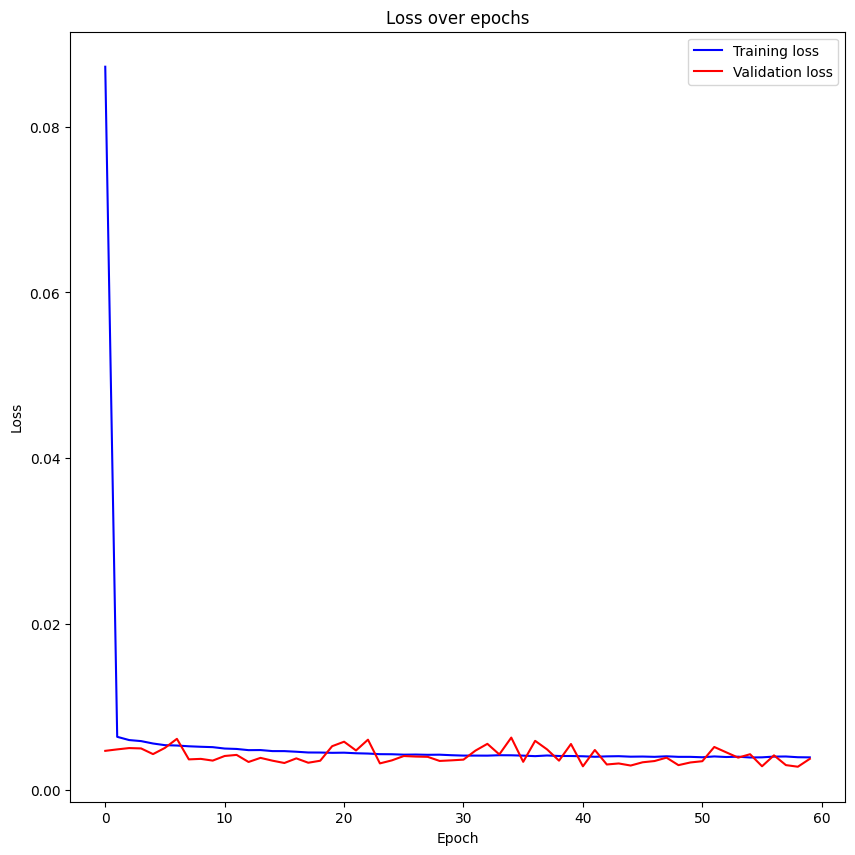

In [66]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs",
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im14.png')
plt.show()

In [67]:
state_dict = torch.load('eth_rnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [68]:

y_pred = []

with torch.no_grad():

    model.eval()

    for x_val, y_val in train_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.min_,scaler.scale_=minmax.min_[0],minmax.scale_[0]
y_pred = torch.cat(y_pred).numpy()

y_pred = scaler.inverse_transform(y_pred).flatten()
y_valid = prices[0:len(prices)-valid_size-12]

rnn_mse = mean_absolute_error(y_valid[:,0], y_pred)
rnn_R2=r2_score(y_valid[:,0], y_pred)
overall['rnn']={'train': {'mae':rnn_mse,"r2":rnn_R2}}
print(f"Training RNN's forecast - MAE: {rnn_mse:.4f},R2: {rnn_R2:.4f}")

Training RNN's forecast - MAE: 1427.0794,R2: -0.9827


In [69]:
y_pred = []

with torch.no_grad():

    model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)


y_pred = torch.cat(y_pred).numpy()

y_pred = scaler.inverse_transform(y_pred).flatten()

RNN's forecast - MAE: 9.2137,R2: 0.9972


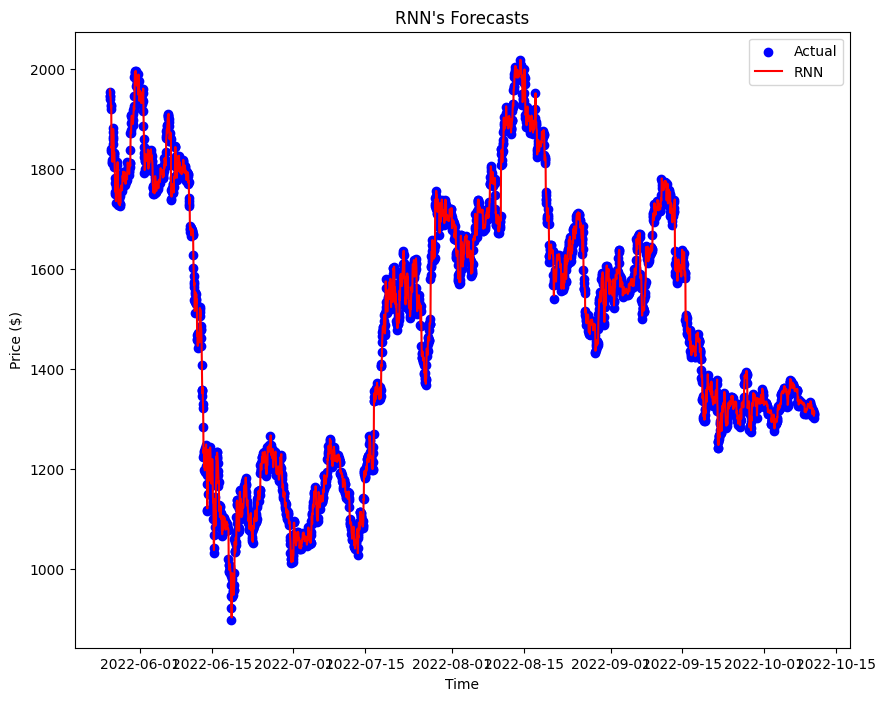

In [70]:
y_valid = prices[len(prices)-valid_size:]

rnn_mse = mean_absolute_error(y_valid[:,0], y_pred)
rnn_R2=r2_score(y_valid[:,0], y_pred)
overall['rnn']['test']={'mae':rnn_mse,"r2":rnn_R2}

print(f"RNN's forecast - MAE: {rnn_mse:.4f},R2: {rnn_R2:.4f}")

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(test_df.index,y_valid[:,0], color='blue', label='Actual')
ax.plot(test_df.index,y_pred, color='red', label='RNN')

ax.set(title="RNN's Forecasts",
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

In [71]:

# facebook model
display(train_df.head())
model = Prophet(seasonality_mode='multiplicative')
model.add_regressor('add1')
model.fit(train_df)

,ETH_price,ETH_returns,ETH_marketcap,ETH_volume,ds,y,add1
timeclose,,,,,,,
2019-01-01 21:59:59.999000+00:00,139.695956,-0.004636,1.454810e+10,NaN,2019-01-01 21:59:59.999,139.695956,1.461575e+10
2019-01-01 22:59:59.999000+00:00,139.968871,0.001954,1.457664e+10,NaN,2019-01-01 22:59:59.999,139.968871,1.454810e+10
2019-01-01 23:59:59.999000+00:00,140.819413,0.006077,1.466532e+10,NaN,2019-01-01 23:59:59.999,140.819413,1.457664e+10
2019-01-02 00:59:59.999000+00:00,141.995471,0.008352,1.478792e+10,NaN,2019-01-02 00:59:59.999,141.995471,1.466532e+10
2019-01-02 01:59:59.999000+00:00,141.125948,-0.006124,1.469747e+10,NaN,2019-01-02 01:59:59.999,141.125948,1.478792e+10


/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -616.393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        125286     0.0113735    1.1162e+06           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        135648    0.00574314        212374           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        139673    0.00103683       94690.6           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        142143   0.000494848       29236.6       0.372      0.0372      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        142346    0.00029103       23491.1           1           1      649   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [72]:
future = train_df[['ds','add1']] # Put in format needed
forecast_insample = model.predict(future) # Get the predictions for the week
forecast_insample.T # Display

/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,0,1,2,3,4,5,6,7,8,9,...,28345,28346,28347,28348,28349,28350,28351,28352,28353,28354
ds,2019-01-01 21:59:59.999000,2019-01-01 22:59:59.999000,2019-01-01 23:59:59.999000,2019-01-02 00:59:59.999000,2019-01-02 01:59:59.999000,2019-01-02 02:59:59.999000,2019-01-02 03:59:59.999000,2019-01-02 04:59:59.999000,2019-01-02 05:59:59.999000,2019-01-02 06:59:59.999000,...,2022-05-25 15:59:59.999000,2022-05-25 16:59:59.999000,2022-05-25 17:59:59.999000,2022-05-25 18:59:59.999000,2022-05-25 19:59:59.999000,2022-05-25 20:59:59.999000,2022-05-25 21:59:59.999000,2022-05-25 22:59:59.999000,2022-05-25 23:59:59.999000,2022-05-26 00:59:59.999000
trend,1262.282255,1262.328794,1262.375332,1262.42187,1262.468409,1262.514947,1262.561486,1262.608024,1262.654562,1262.701101,...,1212.353783,1212.347672,1212.34156,1212.335448,1212.329337,1212.323225,1212.317113,1212.311001,1212.30489,1212.298778
yhat_lower,106.493526,110.15349,109.333629,109.970435,110.462243,110.047227,109.314594,110.314831,109.031515,110.387955,...,1941.150542,1937.455315,1925.703571,1934.815317,1946.171028,1930.440772,1933.993529,1939.880527,1937.450978,1915.543221
yhat_upper,158.739123,158.49944,159.155283,159.1434,160.236763,157.21718,157.584379,161.115836,159.808106,158.619387,...,1991.784529,1986.823612,1975.385836,1983.458987,1995.877021,1979.642198,1984.104794,1990.355696,1984.677006,1966.284492
trend_lower,1262.282255,1262.328794,1262.375332,1262.42187,1262.468409,1262.514947,1262.561486,1262.608024,1262.654562,1262.701101,...,1212.353783,1212.347672,1212.34156,1212.335448,1212.329337,1212.323225,1212.317113,1212.311001,1212.30489,1212.298778
trend_upper,1262.282255,1262.328794,1262.375332,1262.42187,1262.468409,1262.514947,1262.561486,1262.608024,1262.654562,1262.701101,...,1212.353783,1212.347672,1212.34156,1212.335448,1212.329337,1212.323225,1212.317113,1212.311001,1212.30489,1212.298778
add1,-0.895833,-0.896293,-0.896099,-0.895496,-0.894662,-0.895277,-0.895313,-0.895144,-0.895069,-0.895125,...,0.623328,0.619098,0.609751,0.616797,0.626994,0.613729,0.617416,0.621356,0.61902,0.604306
add1_lower,-0.895833,-0.896293,-0.896099,-0.895496,-0.894662,-0.895277,-0.895313,-0.895144,-0.895069,-0.895125,...,0.623328,0.619098,0.609751,0.616797,0.626994,0.613729,0.617416,0.621356,0.61902,0.604306
add1_upper,-0.895833,-0.896293,-0.896099,-0.895496,-0.894662,-0.895277,-0.895313,-0.895144,-0.895069,-0.895125,...,0.623328,0.619098,0.609751,0.616797,0.626994,0.613729,0.617416,0.621356,0.61902,0.604306
daily,0.000357,0.000325,0.00013,-0.000196,-0.0005,-0.000594,-0.000399,-0.000031,0.000271,0.000321,...,-0.000123,-0.000144,-0.000066,0.000054,0.000175,0.000285,0.000357,0.000325,0.00013,-0.000196


/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


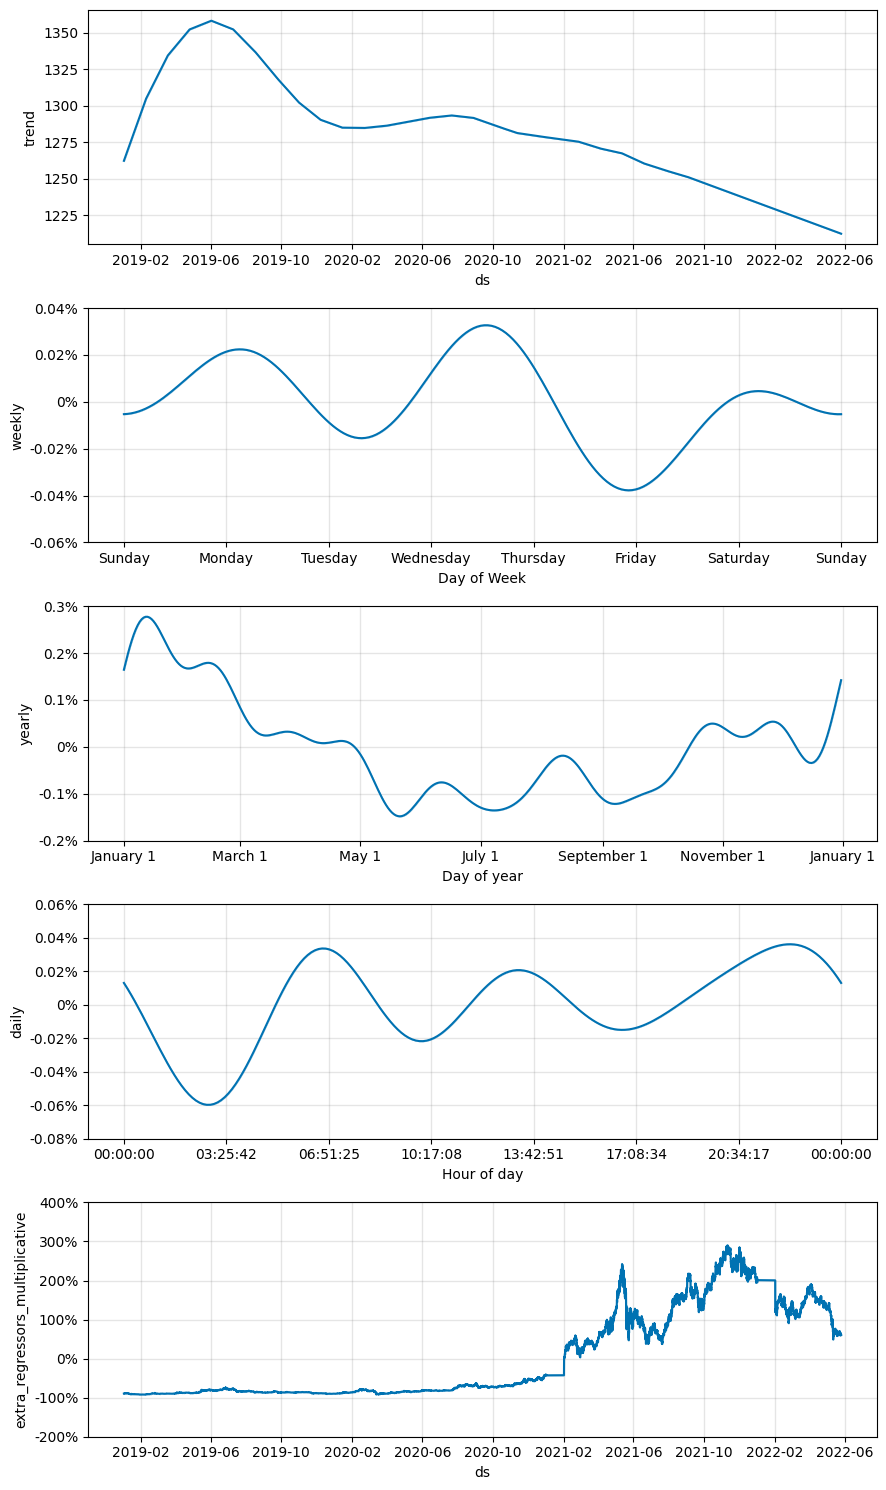

In [73]:
model.plot_components(forecast_insample)
plt.show()

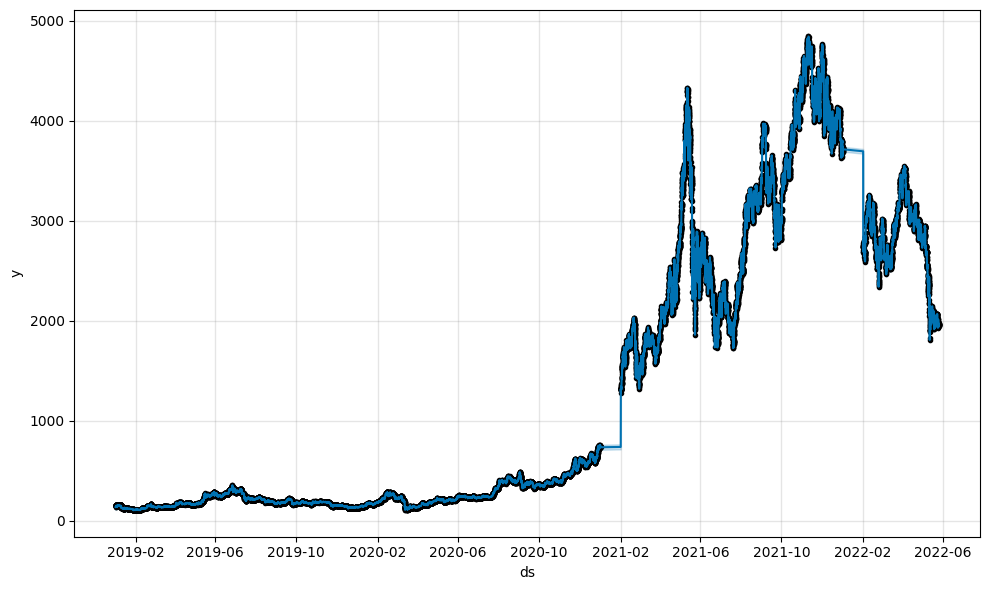

In [74]:
model.plot(forecast_insample);

In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

metric_df = forecast_insample.set_index('ds')[['yhat']].join(train_df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
mae_fb = mean_absolute_error(metric_df.y, metric_df.yhat)
r2_fb = r2_score(metric_df.y, metric_df.yhat)
print(f'Training MAE scores: {mae_fb}')
overall['fb_model']={'train': {'mae':mae_fb,"r2":r2_fb}}



Training MAE scores: 8.297629566810082


In [76]:
future = test_df[['ds','add1']]  # Put in format needed
forecast_insample = model.predict(future)  # Get the predictions for the week
metric_df = forecast_insample.set_index('ds')[['yhat']].join(test_df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
r2_fb_test = r2_score(metric_df.y, metric_df.yhat)
print(f'Testing R2 scores: {r2_fb_test}')
mae_fb_test = mean_absolute_error(metric_df.y, metric_df.yhat)
print(f'Testing MAE scores: {mae_fb_test}')
print(f'Testing Accuracy: {1-mean_absolute_percentage_error(metric_df.y, metric_df.yhat)}')
overall['fb_model']['test']={'mae':mae_fb_test,"r2":r2_fb_test}


/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi510_repo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Testing R2 scores: 0.9973067139941195
Testing MAE scores: 9.039271934703185
Testing Accuracy: 0.9937640781188866


In [77]:
forecast_insample.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-05-26 01:59:59.999,1212.292666,1930.930713,1980.247969,1212.292666,1212.292666,0.614971,0.614971,0.614971,-0.000500,...,0.000086,0.000086,0.000086,-0.001382,-0.001382,-0.001382,0.0,0.0,0.0,1955.639669
1,2022-05-26 02:59:59.999,1212.286555,1917.822442,1968.258437,1212.286555,1212.286555,0.605733,0.605733,0.605733,-0.000594,...,0.000054,0.000054,0.000054,-0.001381,-0.001381,-0.001381,0.0,0.0,0.0,1944.280481
2,2022-05-26 03:59:59.999,1212.280443,1928.792280,1978.096005,1212.280443,1212.280443,0.612237,0.612237,0.612237,-0.000399,...,0.000021,0.000021,0.000021,-0.001379,-0.001379,-0.001379,0.0,0.0,0.0,1952.353021
3,2022-05-26 04:59:59.999,1212.274331,1921.321255,1969.904377,1212.274331,1212.274331,0.605925,0.605925,0.605925,-0.000031,...,-0.000013,-0.000013,-0.000013,-0.001377,-0.001377,-0.001377,0.0,0.0,0.0,1945.099108
4,2022-05-26 05:59:59.999,1212.268220,1913.055533,1962.690056,1212.268220,1212.268220,0.599614,0.599614,0.599614,0.000271,...,-0.000046,-0.000046,-0.000046,-0.001376,-0.001376,-0.001376,0.0,0.0,0.0,1937.766454


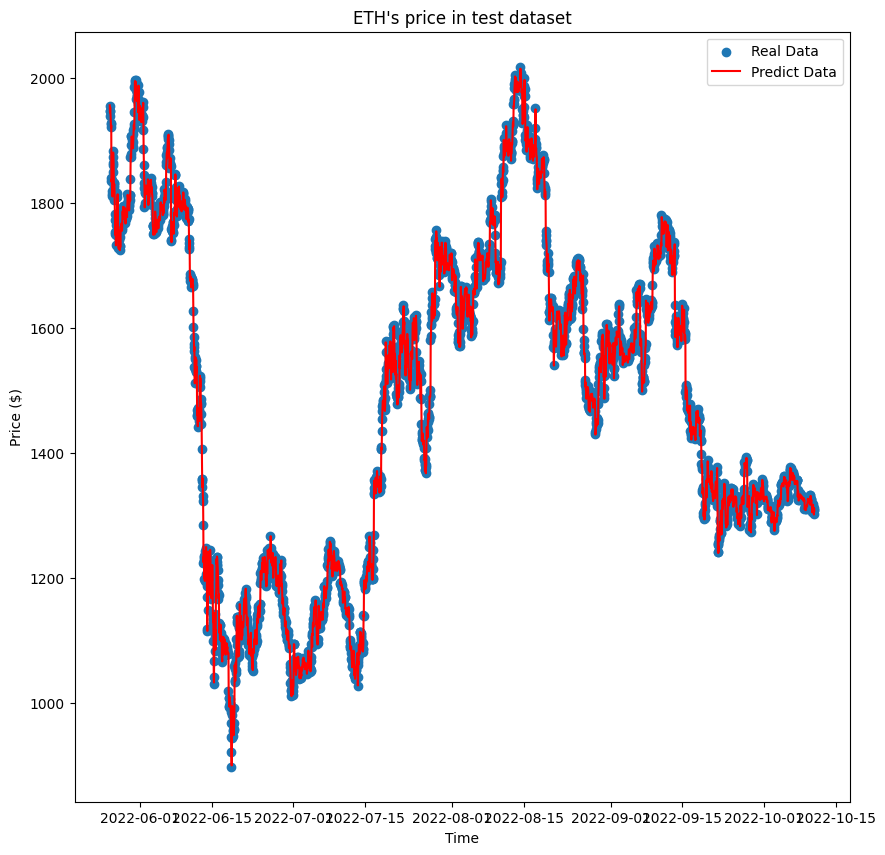

In [78]:
fig, ax = plt.subplots()

ax.scatter(test_df['ds'], test_df['ETH_price'].values.reshape(-1, 1),label='Real Data')
ax.plot(forecast_insample['ds'], forecast_insample['yhat'].values.reshape(-1, 1),label='Predict Data',color='red')
# ax.plot(test_df.index, prices)
ax.legend()
ax.set(title=f"{our_choices[0]}'s price in test dataset",
       xlabel='Time',
       ylabel='Price ($)');

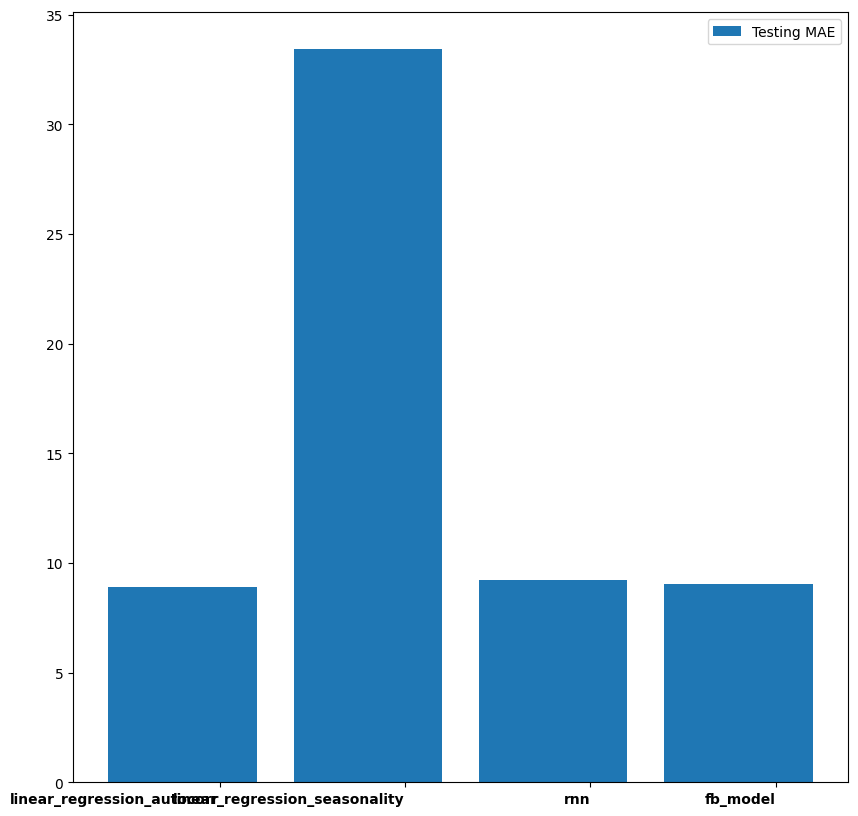

In [79]:
#plot the predict and real data in the graph, and residual plot,compare the models and choose the best one MAE)
import numpy as np
import matplotlib.pyplot as plt

bars = overall.keys()

x = np.arange(len(bars))

plt.xticks(x, bars, fontweight='bold', horizontalalignment='right')

# a = [overall[i]['train']['mae'] for i in bars]
b = [overall[i]['test']['mae'] for i in bars]

total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 3

# plt.bar(x, a,  width=width, label='Testing MAE')
plt.bar(x , b, label='Testing MAE')
plt.legend()
plt.show()


In [80]:
# extra unsupervised learning --Nilaksh--Aider